#### In this notebook first trained models with the imbalance data and then using SMOTE for class balancing and trained all the models by training the data as training and validation and test.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import gc

import warnings
warnings.filterwarnings('ignore')

#increase visibility to see all columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading

In [2]:
#transactions = pd.read_csv('D:\\Upgrad\\LJMU\\data\\fraud\\train_transaction.csv')
transactions = pd.read_csv('train_transaction.csv')
print(transactions.shape)

(590540, 394)


In [3]:
def check_NA_Cols_by_percentage(data, percentage) :
    all_cols = data.isnull().sum()
    print(percentage*len(data))
    na_cols = all_cols[all_cols.values >= (percentage*len(data))]
    print("count of columns where", percentage*100,"% of data is NA : ",len(na_cols))
    print("list of columns where values are NA : \n ", list(na_cols.index))
    return list(na_cols.index)                                          
    

In [4]:
na_cols = check_NA_Cols_by_percentage(transactions, 0.9)    

531486.0
count of columns where 90.0 % of data is NA :  2
list of columns where values are NA : 
  ['dist2', 'D7']


In [5]:
def check_top_values(data, percentage) :
    big_top_value_cols = [col for col in data.columns if data[col].value_counts(dropna=False, normalize=True).values[0] > percentage]
    return big_top_value_cols

In [6]:
top_value_cols = check_top_values(transactions, 0.9)    
print(top_value_cols)

['isFraud', 'dist2', 'C3', 'D7', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321']


In [7]:
drop_cols = list(set(na_cols + top_value_cols))

In [8]:
drop_cols.remove('isFraud')

In [9]:
transactions = transactions.drop(drop_cols, axis=1)

In [10]:
import gc
gc.collect()

11

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
transactions = reduce_mem_usage(transactions)

Mem. usage decreased to 1836.57 Mb (0.6% reduction)


In [13]:
#identity = pd.read_csv('D:\\Upgrad\\LJMU\\data\\fraud\\train_identity.csv')
identity = pd.read_csv('train_identity.csv')

In [14]:
identity.head(2)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device


In [15]:
identity_na_cols = check_NA_Cols_by_percentage(identity, 0.9)

129809.7
count of columns where 90.0 % of data is NA :  9
list of columns where values are NA : 
  ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [16]:
identity_top_value_cols = check_top_values(identity, 0.9)    
print(identity_top_value_cols)

['id_07', 'id_08', 'id_11', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_36']


In [17]:
identity_drop_cols = list(set(identity_na_cols + identity_top_value_cols))

In [18]:
identity_drop_cols

['id_07',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_36',
 'id_27',
 'id_21',
 'id_08',
 'id_11']

In [19]:
identity = identity.drop(identity_drop_cols, axis=1)

In [20]:
identity = reduce_mem_usage(identity)

Mem. usage decreased to 131.21 Mb (0.4% reduction)


In [21]:
joindf = transactions.merge(identity, on='TransactionID', how='left')

In [22]:
del transactions, identity

In [23]:
X_train = joindf.drop('isFraud', axis=1)

In [24]:
y_train = joindf['isFraud'].copy()

In [25]:
train_cols = X_train.columns

In [26]:
del joindf

In [27]:
from sklearn import preprocessing
for f in X_train.columns:
    if X_train[f].dtype=='object' :
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))

In [28]:
X_train.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,2,2,74,103,NaN,260,4,2,2,2,2,1742
1,2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2,2,2,0,1,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [29]:
X_train = X_train.fillna(-999)

In [30]:
X_train.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,4,13926,-999.0,150.0,1,142.0,1,315.0,87.0,19.0,32,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-999.0,13.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.0,13.0,-999.0,-999.0,-999.0,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2,-999.0,-999.0,3,2,-999.0,-999.0,-999.0,-999.0,2,2,74,103,-999.0,260,4,2,2,2,2,1742
1,2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,-999.0,16,32,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)

In [32]:
cols = X_train.columns

In [33]:
from imblearn.over_sampling import SMOTE

In [34]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_std, y_train.ravel())

In [36]:
del X_train, X_std

In [37]:
X_train_res.shape

(1139754, 366)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X, X_test, y, y_test = train_test_split(X_train_res, y_train_res, train_size=0.8, test_size=0.20, random_state=100)

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=100)

In [41]:
del X_train_res

In [42]:
def dumpModel(fileName, model):
    rf_model_pkl = open(fileName, 'wb')
    pickle.dump(model, rf_model_pkl)
    rf_model_pkl.close()
    return

In [43]:
def loadModel(fileName):
    model_pkl = open(fileName, 'rb')
    model = pickle.load(model_pkl)
    print("Loaded model :: ", model)
    return model

In [44]:
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [45]:
def model_metrics(y_test, predictions, modelName):
    print("Printing the metrics for Model : ", modelName)
    print("confusion matrix")
    print(confusion_matrix(y_test,predictions))
    print("Classification report: ")
    print(classification_report(y_test, predictions))
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

### Training xgBoost

In [45]:
import xgboost as xgb

In [46]:
# hyperparameter tuning with XGBoost
from sklearn.model_selection import GridSearchCV

folds = 3

param_grid = {'learning_rate': [0.05,0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


xgb_model = xgb.XGBClassifier(max_depth=10, n_estimators=500, colsample_bytree=0.9,
                        random_state=1,
                        tree_method='gpu_hist')

model_xgb_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [47]:
model_xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 352.8min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.9, max_depth=10,
                                     n_estimators=500, random_state=1,
                                     tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.05, 0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [48]:
xgb_cv_results = pd.DataFrame(model_xgb_cv.cv_results_)
xgb_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,527.874012,2.750618,6.503835,0.010543,0.05,0.3,"{'learning_rate': 0.05, 'subsample': 0.3}",0.998531,0.998404,0.998499,0.998478,0.000054,8,0.999560,0.999609,0.999591,0.999587,2.043136e-05
1,737.343025,5.005547,6.534755,0.018384,0.05,0.6,"{'learning_rate': 0.05, 'subsample': 0.6}",0.998668,0.998490,0.998600,0.998586,0.000073,6,0.999677,0.999708,0.999714,0.999700,1.624103e-05
2,944.475630,2.890005,6.591492,0.012797,0.05,0.9,"{'learning_rate': 0.05, 'subsample': 0.9}",0.998633,0.998467,0.998595,0.998565,0.000071,7,0.999672,0.999722,0.999694,0.999696,2.024275e-05
3,600.844611,4.880881,6.412735,0.019333,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.998805,0.998575,0.998754,0.998711,0.000099,4,0.999999,1.000000,1.000000,1.000000,2.471176e-07
4,813.165658,10.297309,6.494657,0.023970,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.998916,0.998792,0.998914,0.998874,0.000058,2,1.000000,1.000000,1.000000,1.000000,3.715153e-10
5,918.813284,5.789380,6.578799,0.010387,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.999038,0.998831,0.998901,0.998923,0.000086,1,1.000000,1.000000,1.000000,1.000000,1.490745e-09
6,579.823095,6.227440,5.843543,0.043061,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.998217,0.998038,0.998012,0.998089,0.000091,9,1.000000,1.000000,1.000000,1.000000,9.072204e-12
7,807.164333,5.545931,5.748313,0.007915,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.998765,0.998563,0.998632,0.998653,0.000084,5,1.000000,1.000000,1.000000,1.000000,0.000000e+00
8,953.234467,1.708339,5.943989,0.009341,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.998859,0.998676,0.998828,0.998788,0.000080,3,1.000000,1.000000,1.000000,1.000000,0.000000e+00


In [46]:
import pickle

In [51]:
Pkl_Filename_xgb_cv = "Pickle_xgb_gpu_cv_smote_val_test.pkl"  

In [52]:
dumpModel(Pkl_Filename_xgb_cv, model_xgb_cv)

In [53]:
xgb_model_cv = loadModel(Pkl_Filename_xgb_cv)

Loaded model ::  GridSearchCV(cv=3,
             estimator=XGBClassifier(colsample_bytree=0.9, max_depth=10,
                                     missing=nan, n_estimators=500,
                                     random_state=1, tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.05, 0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)


In [54]:
predictions_xgb_cv_val = xgb_model_cv.predict(X_valid)

### xgBoost model Metrics

Printing the metrics for Model :  XGB Model with Cross Validation and SMOTE
confusion matrix
[[113868    177]
 [  1313 112593]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    114045
           1       1.00      0.99      0.99    113906

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

Accuracy for the test dataset 99.3%
ROC for the test dataset 99.3%


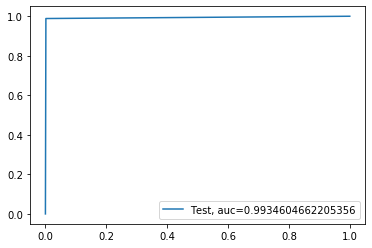

In [55]:
model_metrics(y_valid, predictions_xgb_cv_val, "XGB Model with Cross Validation and SMOTE")

In [56]:
predictions_xgb_cv_test = xgb_model_cv.predict(X_test)

Printing the metrics for Model :  XGB Model with Cross Validation and SMOTE test
confusion matrix
[[113668    146]
 [  1277 112860]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113814
           1       1.00      0.99      0.99    114137

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

Accuracy for the test dataset 99.4%
ROC for the test dataset 99.4%


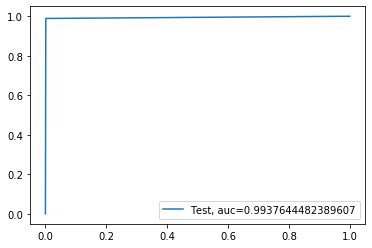

In [57]:
model_metrics(y_test, predictions_xgb_cv_test, "XGB Model with Cross Validation and SMOTE test")

In [67]:
xgb_clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=1,
    tree_method='gpu_hist'
)

In [69]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              n_estimators=500, random_state=1, subsample=0.9,
              tree_method='gpu_hist')

In [49]:
import pickle

In [71]:
Pkl_Filename = "Pickle_xgb_gpu_val_test.pkl"  

In [72]:
dumpModel(Pkl_Filename, xgb_clf)

In [73]:
xgb_model = loadModel(Pkl_Filename)

Loaded model ::  XGBClassifier(colsample_bytree=0.9, learning_rate=0.05, max_depth=10,
              missing=nan, n_estimators=500, random_state=1, subsample=0.9,
              tree_method='gpu_hist')


In [74]:
predictions_xgb_valid = xgb_model.predict(X_valid)

Printing the metrics for Model :  XGB Classification with Hyperparameter tuning for validation
confusion matrix
[[113794    251]
 [  1983 111923]]
Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114045
           1       1.00      0.98      0.99    113906

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

Accuracy for the test dataset 99.0%
ROC for the test dataset 99.0%


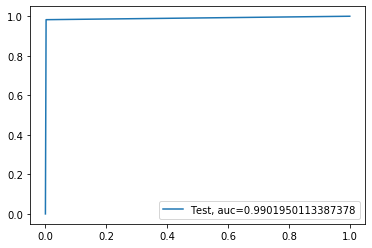

In [75]:
model_metrics(y_valid, predictions_xgb_valid, "XGB Classification with Hyperparameter tuning for validation")

In [79]:
predictions_xgb_test = xgb_model.predict(X_test)

Printing the metrics for Model :  XGB Classification with Hyperparameter tuning for test
confusion matrix
[[113628    186]
 [  1888 112249]]
Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113814
           1       1.00      0.98      0.99    114137

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

Accuracy for the test dataset 99.1%
ROC for the test dataset 99.1%


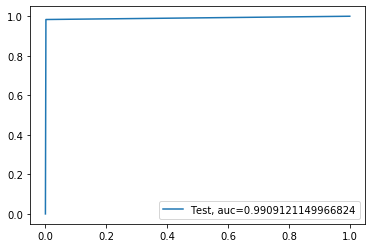

In [80]:
model_metrics(y_test, predictions_xgb_test, "XGB Classification with Hyperparameter tuning for test")

In [82]:
importances = xgb_model.feature_importances_
col_names =  cols

XG_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
XG_imp_features = XG_feature_importance.head(50)

### Top 50 important features from xgBoost model

In [83]:
XG_imp_features

,colName,value
0,0.041402,card1
1,0.038007,addr1
2,0.037456,TransactionAmt
3,0.036835,card2
4,0.027132,TransactionID
5,0.023282,P_emaildomain
6,0.022687,C13
7,0.022442,card5
8,0.019852,C1
9,0.017927,TransactionDT


In [42]:
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [43]:
def model_metrics(y_test, predictions):
    print("confusion matrix")
    print(confusion_matrix(y_test,predictions))
    print("Classification report: ")
    print(classification_report(y_test, predictions))
    accuracy = metrics.accuracy_score(y_test, predictions)
    print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

confusion matrix
[[227334    341]
 [  2846 225381]]
Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    227675
           1       1.00      0.99      0.99    228227

    accuracy                           0.99    455902
   macro avg       0.99      0.99      0.99    455902
weighted avg       0.99      0.99      0.99    455902

Accuracy for the test dataset 99.3%
ROC for the test dataset 99.3%


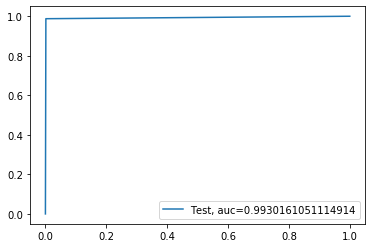

In [35]:
model_metrics(y_valid, predictions_xgb_smote)

In [36]:
from sklearn.metrics import roc_auc_score

In [37]:
print( "  auc = ", roc_auc_score(y_valid, predictions_xgb_smote) )

  auc =  0.9930161051114914


### Training catboost model

In [52]:
from catboost import CatBoostClassifier

In [53]:
model_catboost = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           learning_rate=0.01)

In [54]:
model_catboost.fit(X_train, y_train)

0:	total: 639ms	remaining: 10m 38s
1:	total: 1.17s	remaining: 9m 42s
2:	total: 1.7s	remaining: 9m 26s
3:	total: 2.23s	remaining: 9m 14s
4:	total: 2.77s	remaining: 9m 11s
5:	total: 3.3s	remaining: 9m 7s
6:	total: 3.83s	remaining: 9m 2s
7:	total: 4.35s	remaining: 8m 59s
8:	total: 4.84s	remaining: 8m 53s
9:	total: 5.38s	remaining: 8m 52s
10:	total: 5.92s	remaining: 8m 52s
11:	total: 6.45s	remaining: 8m 50s
12:	total: 6.95s	remaining: 8m 47s
13:	total: 7.45s	remaining: 8m 44s
14:	total: 7.95s	remaining: 8m 41s
15:	total: 8.49s	remaining: 8m 42s
16:	total: 9.01s	remaining: 8m 41s
17:	total: 9.54s	remaining: 8m 40s
18:	total: 10.1s	remaining: 8m 39s
19:	total: 10.6s	remaining: 8m 39s
20:	total: 11.1s	remaining: 8m 37s
21:	total: 11.7s	remaining: 8m 39s
22:	total: 12.2s	remaining: 8m 36s
23:	total: 12.7s	remaining: 8m 38s
24:	total: 13.3s	remaining: 8m 38s
25:	total: 13.8s	remaining: 8m 37s
26:	total: 14.4s	remaining: 8m 38s
27:	total: 14.9s	remaining: 8m 37s
28:	total: 15.5s	remaining: 8m 38

231:	total: 2m 3s	remaining: 6m 49s
232:	total: 2m 4s	remaining: 6m 49s
233:	total: 2m 5s	remaining: 6m 49s
234:	total: 2m 5s	remaining: 6m 48s
235:	total: 2m 6s	remaining: 6m 48s
236:	total: 2m 6s	remaining: 6m 47s
237:	total: 2m 7s	remaining: 6m 47s
238:	total: 2m 7s	remaining: 6m 46s
239:	total: 2m 8s	remaining: 6m 46s
240:	total: 2m 8s	remaining: 6m 45s
241:	total: 2m 9s	remaining: 6m 44s
242:	total: 2m 9s	remaining: 6m 43s
243:	total: 2m 10s	remaining: 6m 43s
244:	total: 2m 11s	remaining: 6m 43s
245:	total: 2m 11s	remaining: 6m 43s
246:	total: 2m 12s	remaining: 6m 43s
247:	total: 2m 12s	remaining: 6m 42s
248:	total: 2m 13s	remaining: 6m 42s
249:	total: 2m 13s	remaining: 6m 41s
250:	total: 2m 14s	remaining: 6m 41s
251:	total: 2m 14s	remaining: 6m 40s
252:	total: 2m 15s	remaining: 6m 39s
253:	total: 2m 16s	remaining: 6m 39s
254:	total: 2m 16s	remaining: 6m 39s
255:	total: 2m 17s	remaining: 6m 38s
256:	total: 2m 17s	remaining: 6m 38s
257:	total: 2m 18s	remaining: 6m 38s
258:	total: 2

456:	total: 4m 3s	remaining: 4m 48s
457:	total: 4m 3s	remaining: 4m 48s
458:	total: 4m 4s	remaining: 4m 47s
459:	total: 4m 4s	remaining: 4m 47s
460:	total: 4m 5s	remaining: 4m 46s
461:	total: 4m 5s	remaining: 4m 45s
462:	total: 4m 5s	remaining: 4m 45s
463:	total: 4m 6s	remaining: 4m 44s
464:	total: 4m 7s	remaining: 4m 44s
465:	total: 4m 7s	remaining: 4m 43s
466:	total: 4m 8s	remaining: 4m 43s
467:	total: 4m 8s	remaining: 4m 42s
468:	total: 4m 9s	remaining: 4m 42s
469:	total: 4m 9s	remaining: 4m 41s
470:	total: 4m 10s	remaining: 4m 41s
471:	total: 4m 10s	remaining: 4m 40s
472:	total: 4m 11s	remaining: 4m 39s
473:	total: 4m 11s	remaining: 4m 39s
474:	total: 4m 12s	remaining: 4m 38s
475:	total: 4m 12s	remaining: 4m 38s
476:	total: 4m 12s	remaining: 4m 37s
477:	total: 4m 13s	remaining: 4m 36s
478:	total: 4m 14s	remaining: 4m 36s
479:	total: 4m 14s	remaining: 4m 35s
480:	total: 4m 15s	remaining: 4m 35s
481:	total: 4m 15s	remaining: 4m 34s
482:	total: 4m 16s	remaining: 4m 34s
483:	total: 4m 

680:	total: 5m 57s	remaining: 2m 47s
681:	total: 5m 57s	remaining: 2m 46s
682:	total: 5m 58s	remaining: 2m 46s
683:	total: 5m 58s	remaining: 2m 45s
684:	total: 5m 59s	remaining: 2m 45s
685:	total: 5m 59s	remaining: 2m 44s
686:	total: 6m	remaining: 2m 44s
687:	total: 6m	remaining: 2m 43s
688:	total: 6m 1s	remaining: 2m 42s
689:	total: 6m 1s	remaining: 2m 42s
690:	total: 6m 2s	remaining: 2m 41s
691:	total: 6m 2s	remaining: 2m 41s
692:	total: 6m 3s	remaining: 2m 40s
693:	total: 6m 3s	remaining: 2m 40s
694:	total: 6m 4s	remaining: 2m 39s
695:	total: 6m 4s	remaining: 2m 39s
696:	total: 6m 5s	remaining: 2m 38s
697:	total: 6m 5s	remaining: 2m 38s
698:	total: 6m 6s	remaining: 2m 37s
699:	total: 6m 6s	remaining: 2m 37s
700:	total: 6m 7s	remaining: 2m 36s
701:	total: 6m 7s	remaining: 2m 36s
702:	total: 6m 7s	remaining: 2m 35s
703:	total: 6m 8s	remaining: 2m 34s
704:	total: 6m 9s	remaining: 2m 34s
705:	total: 6m 9s	remaining: 2m 33s
706:	total: 6m 10s	remaining: 2m 33s
707:	total: 6m 10s	remainin

905:	total: 7m 50s	remaining: 48.8s
906:	total: 7m 50s	remaining: 48.3s
907:	total: 7m 51s	remaining: 47.8s
908:	total: 7m 51s	remaining: 47.2s
909:	total: 7m 52s	remaining: 46.7s
910:	total: 7m 52s	remaining: 46.2s
911:	total: 7m 53s	remaining: 45.7s
912:	total: 7m 54s	remaining: 45.2s
913:	total: 7m 54s	remaining: 44.6s
914:	total: 7m 54s	remaining: 44.1s
915:	total: 7m 55s	remaining: 43.6s
916:	total: 7m 55s	remaining: 43.1s
917:	total: 7m 56s	remaining: 42.6s
918:	total: 7m 57s	remaining: 42s
919:	total: 7m 57s	remaining: 41.5s
920:	total: 7m 57s	remaining: 41s
921:	total: 7m 58s	remaining: 40.5s
922:	total: 7m 59s	remaining: 40s
923:	total: 7m 59s	remaining: 39.4s
924:	total: 7m 59s	remaining: 38.9s
925:	total: 8m	remaining: 38.4s
926:	total: 8m	remaining: 37.9s
927:	total: 8m 1s	remaining: 37.4s
928:	total: 8m 1s	remaining: 36.8s
929:	total: 8m 2s	remaining: 36.3s
930:	total: 8m 2s	remaining: 35.8s
931:	total: 8m 3s	remaining: 35.3s
932:	total: 8m 3s	remaining: 34.7s
933:	total: 

In [55]:
Pkl_Filename_cat = "Pickle_cat_std_smote_val_test.pkl"  

with open(Pkl_Filename_cat, 'wb') as file:  
    pickle.dump(model_catboost, file)

In [56]:
with open(Pkl_Filename_cat, 'rb') as file:  
    Pickled_Model_cat = pickle.load(file)

In [47]:
Pickled_Model_cat

In [57]:
predictions_cat_smote = Pickled_Model_cat.predict(X_valid)

### catboost model metrics

confusion matrix
[[112778   1267]
 [  7444 106462]]
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    114045
           1       0.99      0.93      0.96    113906

    accuracy                           0.96    227951
   macro avg       0.96      0.96      0.96    227951
weighted avg       0.96      0.96      0.96    227951

Accuracy for the test dataset 96.2%
ROC for the test dataset 96.2%


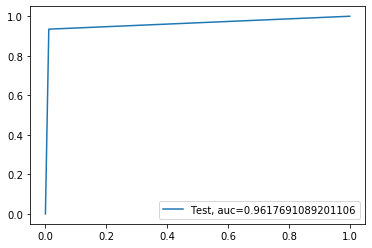

In [58]:
model_metrics(y_valid, predictions_cat_smote)

In [62]:
predictions_cat_smote_test = Pickled_Model_cat.predict(X_test)

confusion matrix
[[112569   1245]
 [  7259 106878]]
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96    113814
           1       0.99      0.94      0.96    114137

    accuracy                           0.96    227951
   macro avg       0.96      0.96      0.96    227951
weighted avg       0.96      0.96      0.96    227951

Accuracy for the test dataset 96.3%
ROC for the test dataset 96.3%


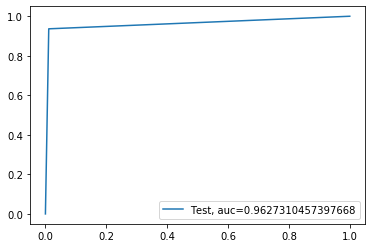

In [63]:
model_metrics(y_test, predictions_cat_smote_test)

In [50]:
import lightgbm as lgb
lgb_smote = lgb.LGBMClassifier()
lgb_smote.fit(X_train, y_train)

LGBMClassifier()

In [51]:
Pkl_Filename_lgbm = "Pickle_lgbm_std_smote.pkl"  

with open(Pkl_Filename_lgbm, 'wb') as file:  
    pickle.dump(lgb_smote, file)

In [52]:
with open(Pkl_Filename_lgbm, 'rb') as file:  
    Pickled_Model_lgbm = pickle.load(file)

In [53]:
predictions_lgbm_smote = Pickled_Model_lgbm.predict(X_valid)

confusion matrix
[[225832   1843]
 [  9968 218259]]
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    227675
           1       0.99      0.96      0.97    228227

    accuracy                           0.97    455902
   macro avg       0.97      0.97      0.97    455902
weighted avg       0.97      0.97      0.97    455902

Accuracy for the test dataset 97.4%
ROC for the test dataset 97.4%


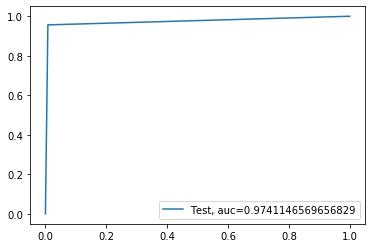

In [54]:
model_metrics(y_valid, predictions_lgbm_smote)

### Training Logistic Regression Model

In [23]:
from sklearn.linear_model import LogisticRegression
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3), "penalty":["l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=5)
lr_model = logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 138.9495494373136, 'penalty': 'l2'}
accuracy : 0.7626094548622792


In [25]:
import pickle
Pkl_Filename_lr = "Pickle_lr_std_smote.pkl"  

with open(Pkl_Filename_lr, 'wb') as file:  
    pickle.dump(lr_model, file)

In [26]:
with open(Pkl_Filename_lr, 'rb') as file:  
    Pickled_Model_lr = pickle.load(file)

In [28]:
predictions_lr_smote = Pickled_Model_lr.predict(X_valid)

### Logistic regression model metrics

confusion matrix
[[180405  47270]
 [ 61094 167133]]
Classification report: 
              precision    recall  f1-score   support

           0       0.75      0.79      0.77    227675
           1       0.78      0.73      0.76    228227

    accuracy                           0.76    455902
   macro avg       0.76      0.76      0.76    455902
weighted avg       0.76      0.76      0.76    455902

Accuracy for the test dataset 76.2%
ROC for the test dataset 76.2%


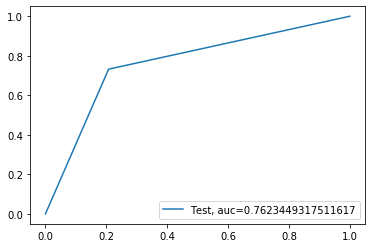

In [32]:
model_metrics(y_valid, predictions_lr_smote)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
from sklearn.model_selection import GridSearchCV

n_folds = 5

params = {'bootstrap': [True, False]}

rf = RandomForestClassifier(
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=20,
                             n_estimators=500)
rf_model_smote = GridSearchCV(rf, params, cv=n_folds, scoring='neg_mean_squared_error')
rf_model_smote.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=20,
                                              min_samples_leaf=100,
                                              min_samples_split=200,
                                              n_estimators=500),
             param_grid={'bootstrap': [True, False]},
             scoring='neg_mean_squared_error')

In [56]:
# scores of GridSearch CV
rf_scores = rf_model_smote.cv_results_
pd.DataFrame(rf_scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,969.283369,13.226663,13.148681,0.074437,True,{'bootstrap': True},-0.101710,-0.100072,-0.102486,-0.100943,-0.101228,-0.101288,0.000802,2
1,1511.524619,5.319559,13.226866,0.102901,False,{'bootstrap': False},-0.101133,-0.099955,-0.101163,-0.099839,-0.100146,-0.100447,0.000580,1


In [57]:
predictions_rf_somte = rf_model_smote.predict(X_valid)

confusion matrix
[[106551   7494]
 [ 15177  98729]]
Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90    114045
           1       0.93      0.87      0.90    113906

    accuracy                           0.90    227951
   macro avg       0.90      0.90      0.90    227951
weighted avg       0.90      0.90      0.90    227951

Accuracy for the test dataset 90.1%
ROC for the test dataset 90.1%


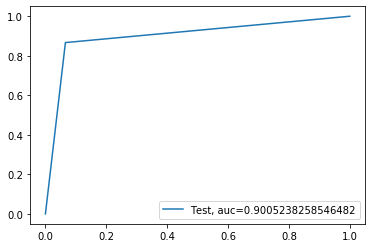

In [58]:
model_metrics(y_valid, predictions_rf_somte)

In [60]:
predictions_rf_somte_test = rf_model_smote.predict(X_test)

confusion matrix
[[106496   7318]
 [ 15206  98931]]
Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.90    113814
           1       0.93      0.87      0.90    114137

    accuracy                           0.90    227951
   macro avg       0.90      0.90      0.90    227951
weighted avg       0.90      0.90      0.90    227951

Accuracy for the test dataset 90.1%
ROC for the test dataset 90.1%


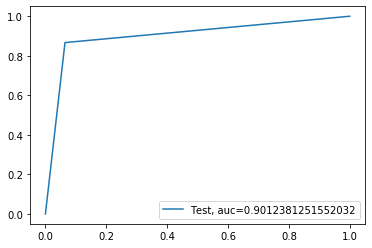

In [61]:
model_metrics(y_test, predictions_rf_somte_test)

In [59]:
import pickle
Pkl_Filename_rf_val_test = "Pickle_rf_std_smote_cv_val_test.pkl"  

with open(Pkl_Filename_rf_val_test, 'wb') as file:  
    pickle.dump(rf_model_smote, file)

### Training lightGBM Model

In [44]:
# hyperparameter tuning with LightGBM
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
folds = 3

param_grid = {'learning_rate': [0.01,0.05, 0.1], 
             'subsample': [0.3, 0.6, 0.9],
             'n_estimators': [500,1000]}          


lgbm_model = lgb.LGBMClassifier(bagging_fraction=0.8, max_depth=10, feature_fraction=0.4,
                                  boosting_type='gbdt')

model_lgbm_cv = GridSearchCV(estimator = lgbm_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)

In [45]:
model_lgbm_cv.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.6 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warni

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 127.1min finished


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.3 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=3,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      feature_fraction=0.4, max_depth=10),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [500, 1000],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [46]:
import pickle
Pkl_Filename_lgbm_cv_val_test = "Pickle_lgbm_std_smote_val_test.pkl"  

with open(Pkl_Filename_lgbm_cv_val_test, 'wb') as file:  
    pickle.dump(model_lgbm_cv, file)

In [47]:
lgbm_cv_results = pd.DataFrame(model_lgbm_cv.cv_results_)
lgbm_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,105.052446,0.084289,4.334069,0.097855,0.01,500,0.3,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989223,0.989146,0.989205,0.989191,0.000033,16,0.989401,0.989389,0.989360,0.989383,0.000017
1,108.162531,0.795978,4.315811,0.011057,0.01,500,0.6,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989223,0.989146,0.989205,0.989191,0.000033,16,0.989401,0.989389,0.989360,0.989383,0.000017
2,106.286356,0.683832,4.248925,0.028938,0.01,500,0.9,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989223,0.989146,0.989205,0.989191,0.000033,16,0.989401,0.989389,0.989360,0.989383,0.000017
3,183.226191,0.341288,8.875630,0.126564,0.01,1000,0.3,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994664,0.994618,0.994684,0.994655,0.000028,13,0.994885,0.994895,0.994867,0.994882,0.000011
4,182.777521,0.808097,8.890910,0.047025,0.01,1000,0.6,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994664,0.994618,0.994684,0.994655,0.000028,13,0.994885,0.994895,0.994867,0.994882,0.000011
5,182.485985,0.790892,8.829645,0.122937,0.01,1000,0.9,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994664,0.994618,0.994684,0.994655,0.000028,13,0.994885,0.994895,0.994867,0.994882,0.000011
6,88.661208,0.322991,4.273709,0.011393,0.05,500,0.3,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997035,0.996975,0.996961,0.996990,0.000032,10,0.997475,0.997570,0.997491,0.997512,0.000041
7,88.838168,0.270520,4.304716,0.035671,0.05,500,0.6,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997035,0.996975,0.996961,0.996990,0.000032,10,0.997475,0.997570,0.997491,0.997512,0.000041
8,89.047345,0.521205,4.240602,0.022424,0.05,500,0.9,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997035,0.996975,0.996961,0.996990,0.000032,10,0.997475,0.997570,0.997491,0.997512,0.000041
9,145.745734,0.261433,7.868386,0.042985,0.05,1000,0.3,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",0.997907,0.997824,0.997853,0.997861,0.000035,4,0.998851,0.998940,0.998865,0.998885,0.000039


In [48]:
with open(Pkl_Filename_lgbm_cv_val_test, 'rb') as file:  
    Pickled_Model_lgbm_cv = pickle.load(file)

In [50]:
predictions_lgbm_cv_valid = Pickled_Model_lgbm_cv.predict(X_valid)

### lightGBM model Metrics

confusion matrix
[[113866    179]
 [  1989 111917]]
Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114045
           1       1.00      0.98      0.99    113906

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

Accuracy for the test dataset 99.0%
ROC for the test dataset 99.0%


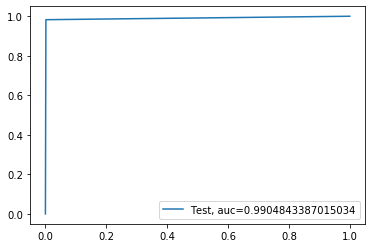

In [51]:
model_metrics(y_valid, predictions_lgbm_cv_valid)

In [52]:
predictions_lgbm_cv_test = Pickled_Model_lgbm_cv.predict(X_test)

confusion matrix
[[113670    144]
 [  1908 112229]]
Classification report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113814
           1       1.00      0.98      0.99    114137

    accuracy                           0.99    227951
   macro avg       0.99      0.99      0.99    227951
weighted avg       0.99      0.99      0.99    227951

Accuracy for the test dataset 99.1%
ROC for the test dataset 99.1%


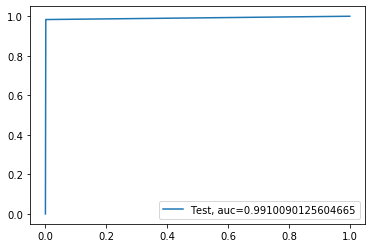

In [53]:
model_metrics(y_test, predictions_lgbm_cv_test)

In [70]:
lgbm_cv_results = pd.DataFrame(model_lgbm_cv.cv_results_)
lgbm_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,104.438253,0.223796,4.210135,0.046340,0.01,500,0.3,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989689,0.988968,0.989073,0.989243,0.000318,16,0.989443,0.989460,0.989404,0.989436,0.000023
1,104.010789,0.486849,4.175606,0.022562,0.01,500,0.6,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989689,0.988968,0.989073,0.989243,0.000318,16,0.989443,0.989460,0.989404,0.989436,0.000023
2,103.834553,0.258338,4.221973,0.047451,0.01,500,0.9,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.989689,0.988968,0.989073,0.989243,0.000318,16,0.989443,0.989460,0.989404,0.989436,0.000023
3,183.513491,0.859456,8.806904,0.036521,0.01,1000,0.3,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994871,0.994690,0.994547,0.994703,0.000133,13,0.994927,0.994919,0.994983,0.994943,0.000028
4,185.030466,0.291234,8.889701,0.062117,0.01,1000,0.6,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994871,0.994690,0.994547,0.994703,0.000133,13,0.994927,0.994919,0.994983,0.994943,0.000028
5,184.489857,1.482684,8.795173,0.064026,0.01,1000,0.9,"{'learning_rate': 0.01, 'n_estimators': 1000, ...",0.994871,0.994690,0.994547,0.994703,0.000133,13,0.994927,0.994919,0.994983,0.994943,0.000028
6,88.351297,0.354453,4.236718,0.037604,0.05,500,0.3,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997102,0.997083,0.996933,0.997039,0.000076,10,0.997547,0.997512,0.997585,0.997548,0.000030
7,89.068992,0.330871,4.255047,0.036313,0.05,500,0.6,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997102,0.997083,0.996933,0.997039,0.000076,10,0.997547,0.997512,0.997585,0.997548,0.000030
8,88.438215,0.535480,4.226954,0.040624,0.05,500,0.9,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.997102,0.997083,0.996933,0.997039,0.000076,10,0.997547,0.997512,0.997585,0.997548,0.000030
9,145.563328,1.004962,7.804265,0.033795,0.05,1000,0.3,"{'learning_rate': 0.05, 'n_estimators': 1000, ...",0.997921,0.997921,0.997804,0.997882,0.000055,6,0.998901,0.998877,0.998885,0.998888,0.000010


In [42]:
import lightgbm as lgb
lgb_smote_opt = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01,
                                  bagging_fraction=0.8, max_depth=10, feature_fraction=0.4,
                                  boosting_type='gbdt')
lgb_smote_opt.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(bagging_fraction=0.8, feature_fraction=0.4, learning_rate=0.01,
               max_depth=10, n_estimators=1000)

In [45]:
Pkl_Filename_lgbm_opt = "Pickle_lgbm_std_smote_opt_val_test.pkl"  

with open(Pkl_Filename_lgbm_opt, 'wb') as file:  
    pickle.dump(lgb_smote_opt, file)

In [46]:
with open(Pkl_Filename_lgbm_opt, 'rb') as file:  
    Pickled_Model_lgbm_opt = pickle.load(file)

In [47]:
predictions_lgbm_smote_val = Pickled_Model_lgbm_opt.predict(X_valid)

confusion matrix
[[113154    891]
 [  5465 108441]]
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    114045
           1       0.99      0.95      0.97    113906

    accuracy                           0.97    227951
   macro avg       0.97      0.97      0.97    227951
weighted avg       0.97      0.97      0.97    227951

Accuracy for the test dataset 97.2%
ROC for the test dataset 97.2%


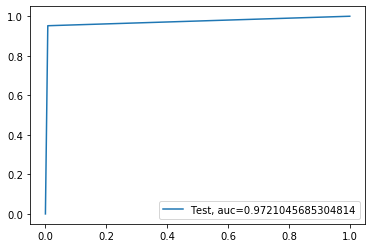

In [48]:
model_metrics(y_valid, predictions_lgbm_smote_val)

In [49]:
predictions_lgbm_smote_test = Pickled_Model_lgbm_opt.predict(X_test)

confusion matrix
[[112937    877]
 [  5388 108749]]
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    113814
           1       0.99      0.95      0.97    114137

    accuracy                           0.97    227951
   macro avg       0.97      0.97      0.97    227951
weighted avg       0.97      0.97      0.97    227951

Accuracy for the test dataset 97.3%
ROC for the test dataset 97.3%


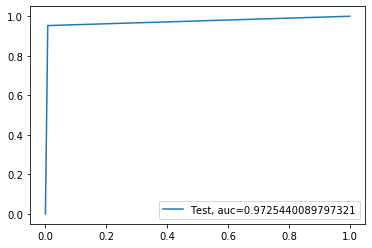

In [51]:
model_metrics(y_test, predictions_lgbm_smote_test)

### Training adaBoostClassifier

In [84]:
from sklearn.ensemble import AdaBoostClassifier

In [85]:
ada_boost = AdaBoostClassifier(n_estimators=500, random_state=0)

In [86]:
ada_boost.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500, random_state=0)

In [87]:
Pkl_Filename_ada = "Pickle_ada_std_smote.pkl"  

In [88]:
dumpModel(Pkl_Filename_ada, ada_boost)

In [89]:
ada_boost_model = loadModel(Pkl_Filename_ada)

Loaded model ::  AdaBoostClassifier(n_estimators=500, random_state=0)


In [92]:
predictions_ada_valid = ada_boost_model.predict(X_valid)

### Adaboost model Metrics

Printing the metrics for Model :  Ada Boost Classification validation with Hyperparameter tuning
confusion matrix
[[111759   2286]
 [  7776 106130]]
Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96    114045
           1       0.98      0.93      0.95    113906

    accuracy                           0.96    227951
   macro avg       0.96      0.96      0.96    227951
weighted avg       0.96      0.96      0.96    227951

Accuracy for the test dataset 95.6%
ROC for the test dataset 95.6%


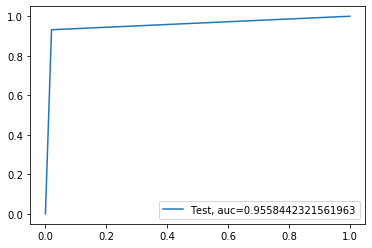

In [91]:
model_metrics(y_valid, predictions_ada_valid, "Ada Boost Classification validation with Hyperparameter tuning")

In [93]:
predictions_ada_test = ada_boost_model.predict(X_test)

Printing the metrics for Model :  Ada Boost Classification validation with Hyperparameter tuning
confusion matrix
[[111440   2374]
 [  7713 106424]]
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    113814
           1       0.98      0.93      0.95    114137

    accuracy                           0.96    227951
   macro avg       0.96      0.96      0.96    227951
weighted avg       0.96      0.96      0.96    227951

Accuracy for the test dataset 95.6%
ROC for the test dataset 95.6%


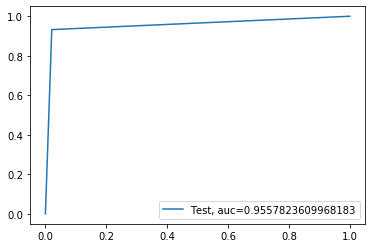

In [95]:
model_metrics(y_test, predictions_ada_test, "Ada Boost Classification validation with Hyperparameter tuning")

### Training SVM Model

In [47]:
from sklearn import svm
from sklearn.svm import SVC

In [48]:
svm_clf = svm.SVC(C= 1, kernel= 'linear', random_state= 0)

In [ ]:
svm_clf.fit(X_train, y_train)

In [ ]:
Pkl_Filename_svm = "Pickle_svm_std_smote_val_test.pkl"  

In [ ]:
dumpModel(Pkl_Filename_svm, svm_clf)

In [ ]:
svm_model = loadModel(Pkl_Filename_svm)

In [ ]:
predictions_svm_smote = svm_model.predict(X_valid)

In [ ]:
model_metrics(y_valid, predictions_svm_smote, "SVM Classification Using SmOTE")

In [ ]:
predictions_svm_smote_test = svm_model.predict(X_test)

In [ ]:
model_metrics(y_test, predictions_svm_smote_test, "Testing SVM Classification Using SMOTE")